# Rainbow


In [2]:
import sys, os
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/utils.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/pmi_movs_2024/hw2/framebuffer.py

!pip -q install gymnasium[atari,accept-rom-license]

!touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: line 9: gdown: command not found
mkdir: cannot create directory './roms': File exists


In [3]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [31]:
import gymnasium as gym
import random
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image


In [32]:
ENV_NAME = "BreakoutNoFrameskip-v4"

# Preprocessing

In [33]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0})

In [34]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [35]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, img, channel_weights=[0.8, 0.1, 0.1]):
      red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
      obs = channel_weights[0] * red + channel_weights[1] * green + channel_weights[2] * blue
      return obs

    def observation(self, img):
        """what happens to each observation"""
        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type


        PIL_img = Image.fromarray(img.astype('uint8'), 'RGB')
        #  * crop image, remove irrelevant parts
        area = (8, 32, 152, 200)
        cropped_img = PIL_img.crop(area)

        #  * resize image to self.img_size
        res_img = cropped_img.resize((64, 64))

        #  * cast image to grayscale
        gray_image = self._to_gray_scale(np.array(res_img))

        #  * convert image pixels to (0,1) range, float32 type
        gray_image = gray_image/255

        image = gray_image.astype(np.float32)
        image = np.expand_dims(image, axis=0)

        return image

# Wrapping

In [36]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer



In [37]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

# DQN as it is

### Building a network


In [38]:

import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [39]:
# https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear - за основу брал это
class NLinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias = True, sigma_zero = 0.5):
        super().__init__()
        self.sigma_zero = sigma_zero
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty((out_features, in_features)))
        self.weight_sigma = nn.Parameter(torch.empty((out_features, in_features)))
        self.weight_eps = nn.Parameter(torch.empty((out_features, in_features)))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
            self.bias_sigma = nn.Parameter(torch.empty((out_features)))
            self.bias_eps = nn.Parameter(torch.empty((out_features)))

        else:
            self.register_parameter('bias', None)
            self.register_parameter('bias_sigma', None)

        self.reset_parameters()
        self.reset_noise()


    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        self.weight.data.uniform_(-1/np.sqrt(self.in_features), 1/np.sqrt(self.in_features))
        self.weight_sigma.data.uniform_(-self.sigma_zero/np.sqrt(self.in_features), self.sigma_zero/np.sqrt(self.in_features))

        if self.bias is not None:
            self.bias.data.uniform_(-1/np.sqrt(self.in_features), 1/np.sqrt(self.in_features))
            self.bias_sigma.data.uniform_(-self.sigma_zero/np.sqrt(self.in_features), self.sigma_zero/np.sqrt(self.in_features))

    def get_function_factorized(self, x):
        return torch.sign(x) * torch.sqrt(torch.abs(x))
    def __gen_noise__(self, size):
        return torch.randn(size)

    def reset_noise(self):
        noise_j = self.__gen_noise__(self.in_features)
        noise_i = self.__gen_noise__(self.out_features)


        self.weight_eps.data.copy_(self.get_function_factorized(torch.outer(noise_i, noise_j)))
        self.bias_eps.data.copy_( self.get_function_factorized(noise_i))


    def forward(self, input):
        if self.training:
            full_weight = self.weight.requires_grad_() + self.weight_sigma.requires_grad_().mul(self.weight_eps)
            if self.bias is not None:
                full_bias   = self.bias.requires_grad_()   + self.bias_sigma.requires_grad_().mul(self.bias_eps)
        else:
            full_weight = self.weight
            if self.bias is not None:
                full_bias  = self.bias

        return torch.nn.functional.linear(input, full_weight, full_bias)


In [40]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, n_quantiles, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.n_quantiles = n_quantiles


        # Define your network body here. Please make sure agent is fully contained here
        self.layer1 = nn.Sequential(nn.Conv2d(4, 16, kernel_size=(3,3), stride=2), nn.ReLU(),
                                    nn.Conv2d(16, 32, kernel_size=(3,3), stride=2), nn.ReLU(), 
                                    nn.Conv2d(32, 64, kernel_size=(3,3), stride=2), nn.ReLU(), 
                                   )
  
        self.layer2 =  nn.Sequential(nn.Linear(3136, 256), nn.ReLU())
        self.layer_value_out = NLinear(256, 1 * n_quantiles)
    
        self.layer_advantage_out = NLinear(256, n_actions * n_quantiles)




    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        x = self.layer1(state_t).flatten(start_dim=1)
        x = self.layer2(x)
        
        advantage = self.layer_advantage_out.forward(x)
        advantage = advantage.reshape(state_t.shape[0], n_actions, self.n_quantiles)

        values = self.layer_value_out.forward(x)
        values = values.reshape(state_t.shape[0], 1, self.n_quantiles)

    

        qvalues = values + (advantage - torch.mean(advantage, dim = 2, keepdim = True))

        
        return qvalues
    def reset_noise(self):
        self.layer_value_out.reset_noise()
        self.layer_advantage_out.reset_noise()


    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float)
        qvalues = self.forward(states.to(device=device))
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions, n_quantiles = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = np.mean(qvalues,axis = 2).argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [41]:
agent = DQNAgent(state_shape, n_actions, n_quantiles = 200, epsilon=0.5).to(device)

In [42]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = np.argmax(np.mean(qvalues, axis = 2), axis=1)[0]  if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

# Experience Replay


In [43]:
import random
import math


In [44]:
class SumTree(object):
    """
    This SumTree code is a modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/SumTree.py

    Story data with its priority in the tree.
    """
    data_pointer = 0

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1) + 1e-5
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
        # [--------------data frame-------------]
        #             size: capacity

    def add(self, p):
        tree_idx = self.data_pointer + self.capacity - 1
        self.update(tree_idx, p)  # update tree_frame

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  # replace when exceed the capacity
            self.data_pointer = 0

    def update(self, tree_idx, p):
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        # then propagate the change through tree
        while tree_idx != 0:    # this method is faster than the recursive loop in the reference code
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        """
        Tree structure and array storage:

        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions

        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_idx = 0
        while True:     # the while loop is faster than the method in the reference code
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return data_idx
        
    def __getitem__(self, indices):
        return self.tree[indices + self.capacity - 1]


    @property
    def total_p(self):
        return self.tree[0]  # the root


In [45]:
np.random.choice(np.arange(0, 10), 5)

array([5, 1, 7, 6, 5])

In [46]:
class ReplayBuffer(object):
    def __init__(self, size, clip_priorities=1.0, rp_alpha=0.4, inv_beta = 0.6):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self.inv_beta = inv_beta
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE
        self.clip_priorities = clip_priorities
        self.rp_alpha = rp_alpha
        self.size = size
        self.priorities_sum = SumTree(size)
        self.first = True
        self.max_priority = 1




    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
            # add data to storage
        if len(self._storage) < maxsize:
          self._storage.append(data)
        else:
          self._storage.pop(0)
          self._storage.append(data)
        self.priorities_sum.add(self.max_priority)




    def sample_indices(self, batch_size):
        '''
        Samples indices using priorities
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        indices: np.array
            batch of indices to sample from replay buffer
        weights: np.array
            batch of importance sampling weights
        """
        '''
        # sample batch_size indices
        indices = np.zeros(batch_size, dtype = np.int32)
        weights = np.ones(batch_size, dtype = np.float64)
        for i in range(batch_size):
            prob = random.random() * (self.priorities_sum.total_p)
            idx = self.priorities_sum.get_leaf(prob)
            indices[i] = idx

        if self.first == True:
            indices = np.random.choice(np.arange(1, min(self.size, len(self._storage))), batch_size)
            self.first = False



        # you can change this to implement bias correction
        weights = np.ones(batch_size)
        min_prob = self.priorities_sum.tree / (self.priorities_sum.total_p)
        norm_prob = np.mean(min_prob[min_prob>0])
        max_weight = norm_prob  ** (-(1 - self.inv_beta))
        if self.priorities_sum.total_p > 0:
            for i in range(batch_size):
                idx = indices[i]
                prob = self.priorities_sum.__getitem__(idx) / (self.priorities_sum.total_p)

                weights[i] =  (prob * self.size + math.ulp(1.0)) ** (-(1 - self.inv_beta))
        weights = weights / max_weight


        return indices, weights


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        storage = self._storage
        # <YOUR CODE>
            # randomly generate batch_size integers
            # to be used as indexes of samples
        indices, weights = self.sample_indices(batch_size)
        obs_batch = np.zeros((batch_size, np.shape(storage[0][0])[0], np.shape(storage[0][0])[1], np.shape(storage[0][0])[2]))
        act_batch = np.zeros(batch_size, dtype = np.int8) # Actions is some kind of int from 0,1,2,3
        rew_batch = np.zeros(batch_size, dtype = np.int8) # Reward is int from atari page
        next_obs_batch = np.zeros((batch_size, np.shape(storage[0][0])[0], np.shape(storage[0][0])[1], np.shape(storage[0][0])[2]))
        done_mask = np.zeros(batch_size, dtype = np.bool_) #either 0 or 1, so it makes sense to choose bool
        # <YOUR CODE>
            # collect <s,a,r,s',done> for each index

        for i, g in enumerate(indices):
          obs_batch[i] = storage[g][0]
          act_batch[i] = storage[g][1]
          rew_batch[i] = storage[g][2]
          next_obs_batch[i] = storage[g][3]
          done_mask[i] = storage[g][4]
        return (obs_batch, act_batch, rew_batch, next_obs_batch, done_mask), indices, weights

            # <states>, <actions>, <rewards>, <next_states>, <is_done>
    def update_priorities(self, indices, new_priorities):
        '''
        Updates priorities with new_priorities on given indices.
        Parameters
        ----------
        indices: np.array
            indices to update
        new_priorities: np.array
            new priorities to set
        '''
        new_priorities = (new_priorities).clip(min=1e-5, max=self.clip_priorities)

        # update priorities
        for idx, priority in zip(indices, new_priorities):
            priority_alpha = priority ** self.rp_alpha
            self.priorities_sum.update(idx, priority_alpha)
            self.max_priority = max(self.max_priority, priority)






In [47]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    if len(np.shape(s)) != 4:
      s = np.expand_dims(s, axis=0)
    sum_rewards = 0


    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
      q_value = agent.get_qvalues(s)
      action = agent.sample_actions(q_value)[0]
      obs, rew, done, _, _ = env.step(action)


      exp_replay.add(np.squeeze(s, axis=0), action, rew, obs, done)



      s = obs
      s = np.expand_dims(s, axis=0)
      sum_rewards += rew

      if done == True:
        s, _ = env.reset()
        if len(np.shape(s)) != 4:
          s = np.expand_dims(s, axis=0)


    return sum_rewards, s



In [49]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    (obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch), _, _= exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks


In [50]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, agent.n_quantiles, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Learning with... Q-learning


In [51]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device,
                    delta = 1):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        selected_next_actions = torch.argmax(torch.mean(agent(next_states), dim = 2), dim = 1) 
        predicted_next_qvalues = target_network(next_states)


    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute V*(next_states) using predicted next q-values
    next_state_values = predicted_next_qvalues[range(states.shape[0]), selected_next_actions] 


    target_qvalues_for_actions = rewards.unsqueeze(1) + gamma * is_not_done.unsqueeze(1) * next_state_values

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"
    
    qvalues_difference_matrix = predicted_qvalues_for_actions.unsqueeze(2) - target_qvalues_for_actions.unsqueeze(1)
    qvalues_difference_matrix.requires_grad_()
    
    quantile = np.linspace(0.0, 1.0, predicted_qvalues.shape[-1] + 1)
    quantile_midpoint = torch.tensor((quantile[1:] + quantile[:-1])/2, device=device, dtype=torch.float) 
    quantile_midpoint = quantile_midpoint.view(1, -1, 1)

    loss_function = nn.HuberLoss(reduction = 'none', delta=delta)
    loss_function.requires_grad_()
    
    qunatile_loss = loss_function(predicted_qvalues_for_actions.unsqueeze(2), target_qvalues_for_actions.unsqueeze(1))/delta
    qunatile_loss.requires_grad_()

    loss = torch.mean(torch.mean(torch.abs(quantile_midpoint - qvalues_difference_matrix.le(0.).int()) * qunatile_loss, dim = 1), 1)

    return loss

# Main loop


In [52]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [53]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [54]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [55]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()
n_quantiles = 50
agent = DQNAgent(state_shape, n_actions, n_quantiles, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions, n_quantiles).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [56]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [57]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1



loss_freq = 50
refresh_target_network_freq = 500 
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [58]:
init_inv_beta = 0.4
final_inv_beta = 0


In [59]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.81100f


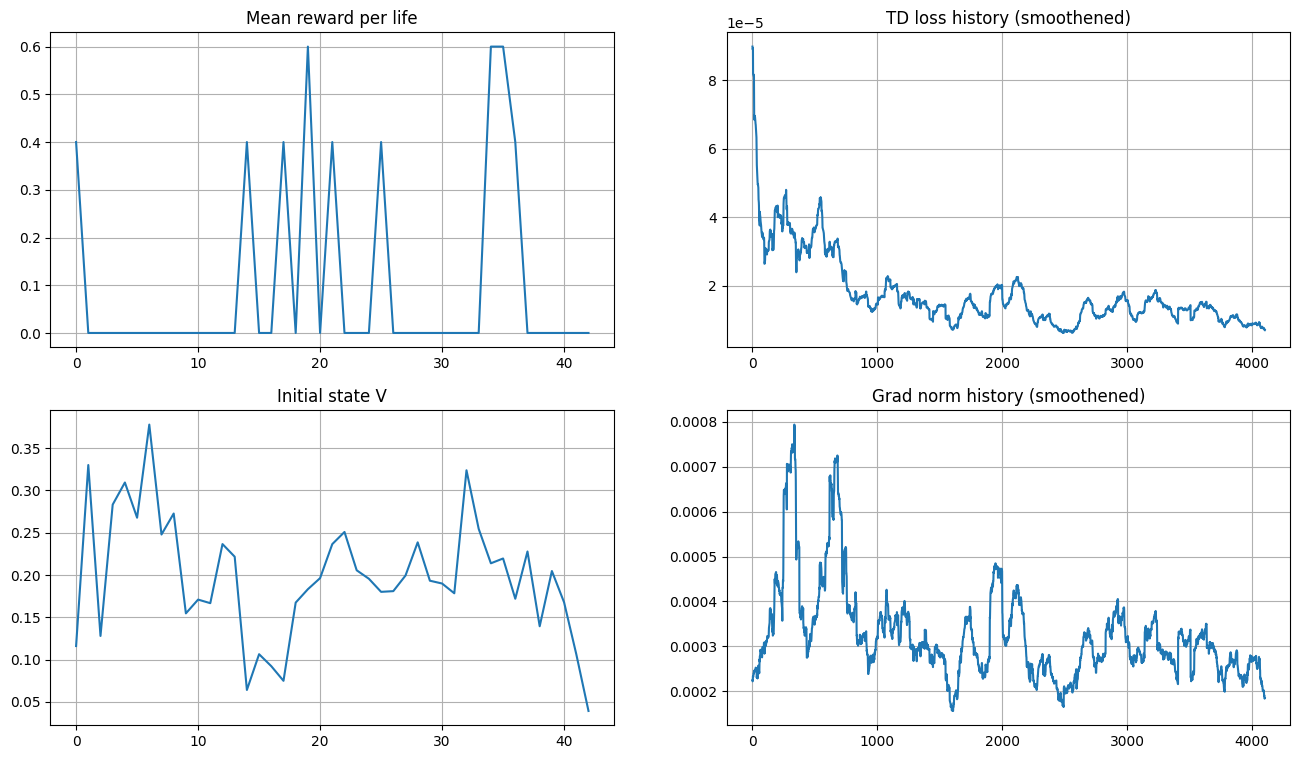

  7%|▋         | 214236/3000001 [1:05:41<12:59:20, 59.57it/s] 

In [ ]:
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)
    agent.inv_beta = utils.linear_decay(init_inv_beta, final_inv_beta, step, decay_steps)


    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    (states, actions, rewards, next_states, is_done), indices, weights = exp_replay.sample(batch_size)

    loss_by_sample = compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device)
    weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)
    loss = torch.mean(loss_by_sample * weights)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()
    
    loss_prior = loss_by_sample.detach().cpu().numpy()
    new_priorities = loss_prior + 1e-6
    exp_replay.update_priorities(indices, new_priorities)
    
    agent.reset_noise()
    target_network.reset_noise()
    
    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5ff"  %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()
        
    if mean_rw_history[-1] > 5:
        torch.save(agent.state_dict(), 'Rainbow_agent.pth')
        torch.save(target_network.state_dict(), 'Rainbow_target_network.pth')
        save_object(exp_replay, 'Rainbow_exp_replay.pkl')
        break

In [ ]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 15, 'not as cool as DQN can'
print('Cool!')